# Name = Taher Darwesh
# City ID = adbr133 

## Setup dependencies

In [ ]:
try:
    import google.colab
    import subprocess
    import os.path
    p = subprocess.run(['git', 'rev-parse', '--is-inside-work-tree'], stdout=subprocess.PIPE, universal_newlines=True)
    if p.stdout == 'true\n':
        !git pull
    else:
        if not os.path.isdir('city_dsp_ap'):
            !git clone --depth 1 -q https://github.com/tweyde/city_dsp_ap.git
        %cd city_dsp_ap
except:
    %cd city_dsp_ap

/content/city_dsp_ap


In [ ]:
import numpy as np
from scipy import fft, signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
from IPython.display import Audio, display

## Controllable delay line (UG) or filter (PG)

You will need to create a function that applies the desired effect to any input signal, where the effect can be dynamically modified by a control signal. The functions only need to be implemented for offline use, so you don't need to be handle input buffers of arbitrary sizes like in lab 6. It suffices to use a single for loop to run over all samples of the input and control signals, and create the output sample-by-sample.

In both cases, the control signal will be a sine of 2Hz. Create one of the required length yourself. Any signal should work as input signal. You can learn how to [upload your own files](https://colab.research.google.com/notebooks/io.ipynb) into Google Colab, but the easiest will be to use one of the wave files available in the `audio` directory. If you're loading a stereo file, it is allowed to mix it down into a single mono channel before passing it to the effect to simplify processing.

In [ ]:
%ls audio/*.wav

audio/20-16000HzExp5sec.wav  audio/carrier.wav*  audio/rockB.wav
audio/20-16000HzLin5sec.wav  audio/rockA.wav


#### UG
Program a controllable delay line. Mix the output with the original input to create a flanging effect. Use the control signal to vary the amount of delay between zero and a maximum value (1 millisecond would be a good default for this, use the samplerate to calculate how much samples this is).

#### PG
Program a controllable FIR filter, i.e. a filter that changes its characteristics over time in response to a control signal. Apply the filter to the signal by implementing a convolution with the filter coefficients in a loop over the samples, just like in lab 7. In order to make the filter respond to the control signal, you can either design two static filters and interpolate between them (like in lab 7), or you can directly manipulate the filter characteristics in the filter design function [`firls`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) and call it for every iteration.

Text(0.5, 1.0, 'Control Signal')

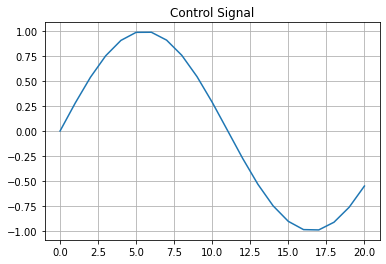

In [ ]:
# write your code here

# define the plot fuction
def plot_filter(b, a, samplerate=None):
    # Compute the frequency response of a digital filter
    w, h = signal.freqz(b, a)

    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')
    freqs = w / (2*np.pi)
    if samplerate:
        freqs *= samplerate
        ax1.set_xlabel('frequency [Hz]')
    else:
        ax1.set_xlabel('normalised frequency [cycles/sample]')

    ax1.plot(freqs, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('amplitude [dB]', color='b')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(freqs, angles, 'g')
    ax2.set_ylabel('angle [radians]', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

# Define the convolution fuction
def convolution_loop(filt_coeff, samples):
    filt_len = len(filt_coeff)
    sig_len = len(samples)
    conv_len = sig_len + filt_len -1
    flip_coeff = np.flip(filt_coeff)
    pad_len = conv_len - sig_len
    samples = np.pad(samples, (pad_len,0), 'constant', constant_values = 0)
    filtered_samples = np.zeros(conv_len)
    for i_conv in range(sig_len):
        filtered_samples[i_conv] = np.dot(samples[i_conv:i_conv + filt_len], flip_coeff)
    return filtered_samples


# read the input file
samplerate, samples = wavfile.read('audio/rockA.wav') # Input file
mono_samples = np.mean(samples, axis=-1) # Stereo to Mono

# design two filters - low and high pass
filt_len = 21 # Filter length
# Design a lowpass filter
lp_coeff = signal.firls(filt_len, [0, 500, 700, samplerate/2], [1, 1, 0, 0], fs=samplerate)
# Design a highpass filter
hp_coeff = signal.firls(filt_len, [0, 500, 700, samplerate/2], [0, 0, 1, 1], fs=samplerate)


# Generate the control signal
freq = 2 # fundamental frequency in Hz
ctrl_samplerate = samplerate/1000  # Arbitary sampling frequency for control signal
t = (np.linspace(0, filt_len-1,filt_len)) # time index
ctrl = np.sin(2 * np.pi * freq * t/ctrl_samplerate) # Control signal of 2Hz
plt.figure()
plt.plot(t,ctrl)
plt.grid(True)
plt.title("Control Signal")

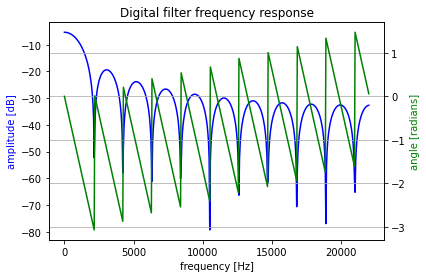

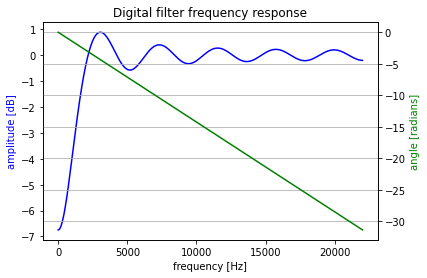

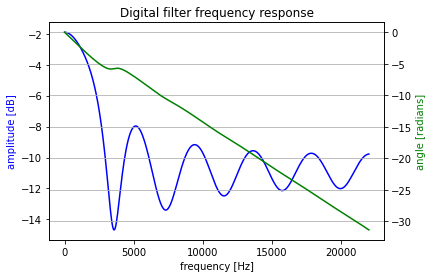

In [ ]:
# Interpolated filter
inter_coeff = (1 - ctrl) * lp_coeff + ctrl * hp_coeff
# Plot the frequency response
plt.close("all")
plot_filter(lp_coeff,1,samplerate)
plot_filter(hp_coeff,1,samplerate)
plot_filter(inter_coeff,1,samplerate)

In [ ]:
#Perform the filtering with interpolated filter through the convolution function
fil_out = convolution_loop(inter_coeff, mono_samples)

In [ ]:
amplitude = np.iinfo(np.int16).max # Maximum value of int16
data = amplitude * fil_out
wavfile.write('audio/rockA_fil.wav', samplerate, data) # Write to the file

## Digit recognition (UG & PG)

In this part, you're going to use images of handwritten digits ranging from 0 to 9. They are split in a training set and a test set and stored as text files in `data/digits-training.txt` and `data/digits-test.txt`.

In [ ]:
%ls data/digits-*.txt

data/digits-test.txt*  data/digits-training.txt*


In [ ]:
from itertools import islice
import re

def read_digit_pixels_and_labels(path):
    with open(path) as f:
        header = list(islice(f, 21))
        pixel_height = [int(x[1]) for x in map(lambda r: re.match('entheight = (\d+)', r), header) if x][0]
        num_digits = [int(x[1]) for x in map(lambda r: re.match('ntot = (\d+)', r), header) if x][0]
        digit_pixels = []
        labels = []
        for _ in range(num_digits):
            chunk = list(islice(f, pixel_height+1))
            digit_pixels.append(np.loadtxt(chunk[:-1]))
            labels.append(int(chunk[-1]))
    return digit_pixels, labels

Since the text files have a custom format, a loader function `read_digit_pixels_and_labels` is provided.

In [ ]:
training_digits, training_labels = read_digit_pixels_and_labels('data/digits-training.txt')
test_digits, test_labels = read_digit_pixels_and_labels('data/digits-test.txt')

In [ ]:
len(training_digits), len(training_labels), len(test_digits), len(test_labels)

(1934, 1934, 943, 943)

All digits and their associated labels have now been read into lists, so we can use list indexing to access them and, for instance, display them as below.

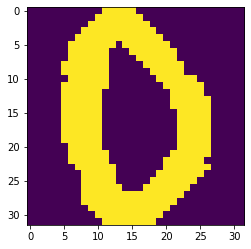

Image of digit 0


In [ ]:
index = 1
plt.figure()
plt.imshow(training_digits[index])
plt.show()
print('Image of digit {}'.format(training_labels[index]))

Using this data, your task is to:

1. Create a function for comparing each test image with the collection of training images, using the correlation with each training image without offset (i.e. calculate the sum of the element-wise multiplied images).
2. Estimate the most likely label for each test image by matching with the training image that has maximal correlation.
3. Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.
4. Use the two-dimensional correlation function [`signal.correlate2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html) to find the best match over all image offsets. For efficiency you can use a subset of the training images, or calculate an average of the training images.
5. Implement variants of the digit recognition system, e.g.
    - use the negatives of the training and test images instead of the positive images
    - use images that are slightly rotated in your training set (using [`rotate`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate) from the `scikit-image.transform` library)
    - use images with some noise added in your training set (using [`random_noise`](https://scikit-image.org/docs/dev/api/skimage.util.html#random-noise) from the `scikit-image.util` library)
6. Report the accuracy of the new system and compare with the accuracy of the previous systems.
7. In the written report, discuss and reason about the different performances of your classifiers.

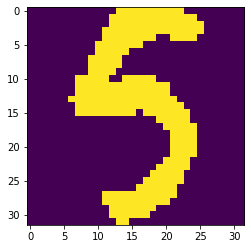

Image of test digit 5


In [ ]:
# write your code here

# import packages
from scipy import signal
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise, invert
from itertools import islice
import re

# function for comparing testing and training sets
def compare_test_training(test, training):
    train_len = len(training)
    # array of zeros
    corr_val = np.zeros(train_len)
    i = 0
    for train in training:
        # sum element wise
        corr_val[i] = np.sum(test * train)
        i += 1
    return corr_val
# print image at index 2
index = 2
plt.figure()
plt.imshow(test_digits[index])
plt.show()
print('Image of test digit {}'.format(test_labels[index]))

In [ ]:
# Estimate the likely label
# sample image
index = 2
# run our function
cor_val = compare_test_training(test_digits[index], training_digits)
# take max value
identified_label = training_labels[np.argmax(cor_val)]
print("The actual test label is %d and the identified label is %d" 
      %(test_labels[index], identified_label))

The actual test label is 5 and the identified label is 5


In [ ]:
# Check all the test_digits for accuracy
i = 0
train_len = len(test_digits)
# array of zeros
identified_label = np.zeros(train_len)
#loop on test set
for test in test_digits:
    # run function
    cor_val = compare_test_training(test, training_digits)
    identified_label[i] = training_labels[np.argmax(cor_val)]
    i += 1
# Compare the identified label with the test_labels
tot_correct = np.sum(identified_label == test_labels)
# calculate percentage
accuracy = tot_correct / train_len
print("Accuracy of the system = %.2f %%" %(accuracy * 100))

Accuracy of the system = 90.14 %


In [ ]:
# Correlation using correlate2d
def compare_corr_test_training(test, training, slen):
    train_len = len(training)
    corr_val = np.zeros(train_len)
    i = 0
    for train in training[0:slen]:
        scorr_val =  signal.correlate2d(train, test, boundary='symm', mode='same')
        corr_val[i] = scorr_val.max()
        i += 1
    return corr_val

In [ ]:
# Correlate 2d
slen = 50  # Taking the subset of the training_digits
i = 0
train_len = len(test_digits)
identified_label = np.zeros(train_len)
for test in test_digits:
    cor_val = compare_corr_test_training(test, training_digits, slen)
    identified_label[i] = training_labels[np.argmax(cor_val)]
    i += 1
# Compare the identified label with the test_labels
tot_correct = np.sum(identified_label == test_labels)
accuracy = tot_correct / train_len
print("Accuracy of the system with corr2d = %.2f %%" %(accuracy * 100))

Accuracy of the system with corr2d = 50.80 %


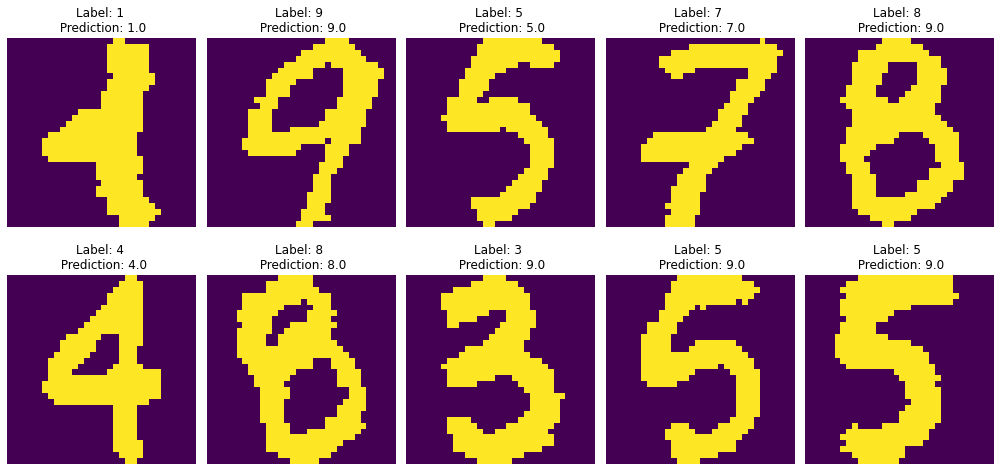

In [ ]:
# plot first 10 test images with their labels and predictions
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(test_digits[i])
    ax[i].set_title(f'Label: {test_labels[i]} \n Prediction: {identified_label[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
# define function for inversion
def compare_invert_test_training(test, training):
    train_len = len(training)
    corr_val = np.zeros(train_len)
    i = 0
    for train in training:
        corr_val[i] = np.sum(invert(test) * invert(train))
        i += 1
    return corr_val

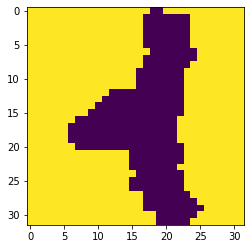

Inverted Image of test digit 1


In [ ]:
# Invertion of image sample
index = 0
plt.figure()
plt.imshow(invert(test_digits[index]))
plt.show()
print('Inverted Image of test digit {}'.format(test_labels[index]))

In [ ]:
i = 0
train_len = len(test_digits)
identified_label = np.zeros(train_len)
for test in test_digits:
    cor_val = compare_invert_test_training(test, training_digits)
    identified_label[i] = training_labels[np.argmax(cor_val)]
    i += 1
# Compare the identified label with the test_labels
tot_correct = np.sum(identified_label == test_labels)
accuracy = tot_correct / train_len
print("Accuracy of the system with inversion = %.2f %%" %(accuracy * 100))

Accuracy of the system with inversion = 90.88 %


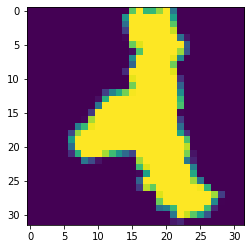

Rotate Image of test digit 1


In [ ]:
# Rotate image
index = 0
plt.figure()
plt.imshow(rotate(test_digits[index],10))
plt.show()
print('Rotate Image of test digit {}'.format(test_labels[index]))

In [ ]:
# define function for rotation
def compare_rotate_test_training(test, training):
    train_len = len(training)
    corr_val = np.zeros(train_len)
    i = 0
    for train in training:
        rotate(train, 10) 
        corr_val[i] = np.sum(test * train)
        i += 1
    return corr_val

In [ ]:
# Rotate image
i = 0
train_len = len(test_digits)
identified_label = np.zeros(train_len)
for test in test_digits:
    cor_val = compare_rotate_test_training(test, training_digits)
    identified_label[i] = training_labels[np.argmax(cor_val)]
    i += 1
# Compare the identified label with the test_labels
tot_correct = np.sum(identified_label == test_labels)
accuracy = tot_correct / train_len
print("Accuracy of the system with rotation = %.2f %%" %(accuracy * 100))

Accuracy of the system with rotation = 90.14 %


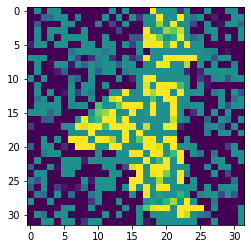

Rotate Image of test digit 1


In [ ]:
# Rotate image
index = 0
zero_image = test_digits[index] * 0
noisy_im = random_noise(zero_image, mode='gaussian', mean=0, var=5)
n_image = noisy_im + test_digits 
plt.figure()
plt.imshow(n_image[index])
plt.show()
print('Rotate Image of test digit {}'.format(test_labels[index]))

In [ ]:
# define function for noise
def compare_noisy_test_training(test, training):
    train_len = len(training)
    corr_val = np.zeros(train_len)
    zero_image = training[0] * 0
    noisy_im = random_noise(zero_image, mode='gaussian', mean=0, var=5)
    i = 0
    for train in training:
        n_image = noisy_im + train 
        corr_val[i] = np.sum(test * n_image)
        i += 1
    return corr_val

In [ ]:
# Noisy image
i = 0
train_len = len(test_digits)
identified_label = np.zeros(train_len)
for test in test_digits:
    cor_val = compare_noisy_test_training(test, training_digits)
    identified_label[i] = training_labels[np.argmax(cor_val)]
    i += 1
# Compare the identified label with the test_labels
tot_correct = np.sum(identified_label == test_labels)
accuracy = tot_correct / train_len
print("Accuracy of the system with noise = %.2f %%" %(accuracy * 100))

Accuracy of the system with noise = 90.24 %


## Time series prediction with financial data (UG pairs & PG)

In this part, you're going to use long term US stock market data (monthly indices, dividends, earnings, etc. since 1871). Information about the data provenance and references can be found at http://www.econ.yale.edu/~shiller/data.htm (especially the 2nd paragraph). The data is available in the file `data/financial_data.csv`.

It is stored as comma-separated numerical values, with a header containing column names. Therefore we can use [`np.genfromtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) to read it.

In [ ]:
financial = np.genfromtxt('data/financial_data.csv', delimiter=',', skip_header=2, names=True)

The result is a structured array, which means that we can access each of the columns in the table by its name. The list of all colums can be found below.

In [ ]:
financial.dtype.names

('Date',
 'SP_Comp_P',
 'Dividend_D',
 'Earnings_E',
 'Consumer_Price_Index_CPI',
 'Date_Fraction',
 'Long_Interest_Rate_GS10',
 'Real_Price',
 'Real_Dividend',
 'Real_Earnings',
 'Cyclically_Adjusted_Price_Earnings_Ratio_PE10_or_CAPE')

You can access the columns using their names between square brackets, like you would for a dictionary. It's advised to store the columns you need in helper variables, to avoid long statements resulting from the long column names.

In [ ]:
date = financial['Date']
real_price = financial['Real_Price']

Now you can easily use the data, for instance to plot it.

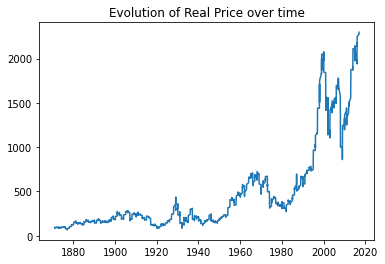

In [ ]:
plt.figure()
plt.plot(date, real_price)
plt.title('Evolution of Real Price over time')
plt.show()

Using this data, your task is to:

1. Look for long term trends on a linear and log scale and de-trend the data first.
2. Calculate the FFT of the signal of interest, to estimate possible periodicities. You can use a window to avoid spectral leaking.
3. Refine your analysis by adjusting the size of the dataset (e.g. if you model annual patterns, make sure your dataset size is a multiple of 12).

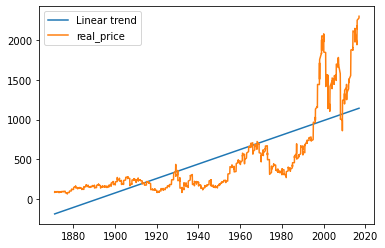

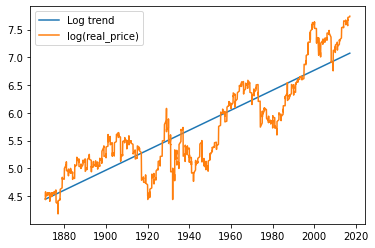

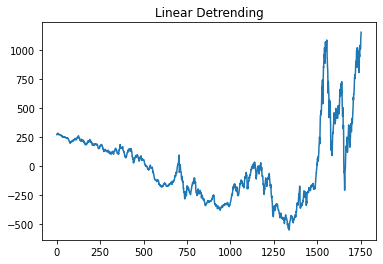

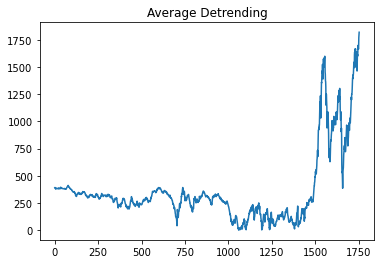

In [ ]:
# write your code here

# import packages
from sklearn.linear_model import LinearRegression
from scipy.fft import fft

# Linear long term tred
dt = np.reshape(date, (len(date), 1))
Linear_model = LinearRegression()
Linear_model.fit(dt, real_price)
linear_trend = Linear_model.predict(dt)
plt.plot(dt,linear_trend)
plt.plot(dt,real_price)
plt.legend(['Linear trend','real_price'])
plt.show()

# Log long term tred
log_model = LinearRegression()
log_model.fit(dt,np.log(real_price))
log_trend = log_model.predict(dt)
plt.plot(dt,log_trend)
plt.plot(dt,np.log(real_price))
plt.legend(['Log trend','log(real_price)'])
plt.show()

# detrend by model fitting
detrend = [real_price[i] - linear_trend[i] for i in range(0, len(real_price))]
plt.plot(detrend)
plt.title('Linear Detrending')
plt.show()

# average detrending
avg = np.mean(real_price)
detrend2 = real_price - avg
plt.figure()
plt.plot(np.abs(detrend2))
plt.title('Average Detrending')
plt.show()

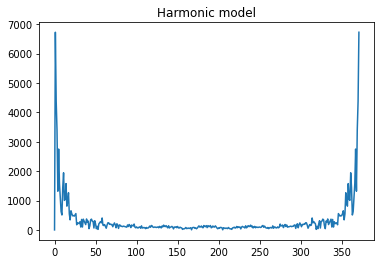

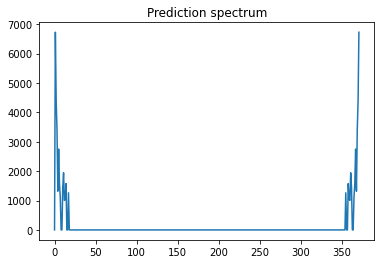

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


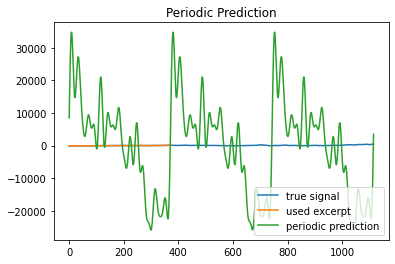

In [ ]:
# Part 2
excerpt_length = 12*31 # daily level
excerpt = financial['Real_Price'][:excerpt_length]
avg = np.mean(excerpt)
norm_excerpt = excerpt - avg
#norm_excerpt =  np.vectorize(signal.hann(norm_excerpt))
harmonic_model = fft(norm_excerpt)

plt.figure()
plt.plot(np.abs(harmonic_model))
plt.title('Harmonic model')
plt.show()

threshold = 1000
predict_spectrum = np.where(np.abs(harmonic_model) < threshold, 0, harmonic_model)

plt.figure()
plt.plot(np.abs(predict_spectrum))
plt.title('Prediction spectrum')
plt.show()

prediction = fft(predict_spectrum)

test_length = 2 # expressed as number of times the excerpt length
total_length = (test_length + 1) * excerpt_length

true_signal = financial['Real_Price'][:total_length] - avg
periodic_prediction = np.tile(prediction, test_length+1)

plt.figure()
plt.plot(true_signal, label='true signal')
plt.plot(norm_excerpt, label='used excerpt')
plt.plot(periodic_prediction, label='periodic prediction')
plt.legend(loc='lower right')
plt.title('Periodic Prediction')
plt.show()

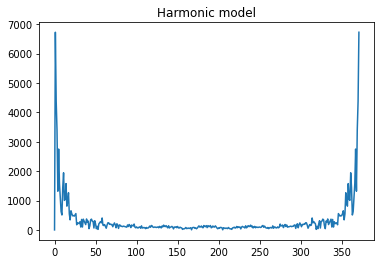

In [ ]:
# Part 3
excerpt_length2 = 12 * 5 # five year period
excerpt = financial['Real_Price'][:excerpt_length]
avg = np.mean(excerpt)
norm_excerpt = excerpt - avg               
harmonic_model = fft(norm_excerpt)

plt.figure()
plt.plot(np.abs(harmonic_model))
plt.title('Harmonic model')
plt.show()

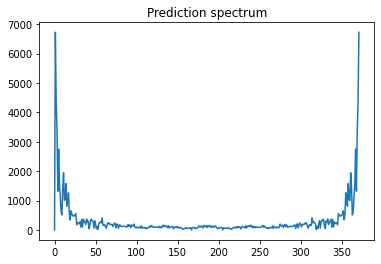

In [ ]:
threshold = 5
predict_spectrum = np.where(np.abs(harmonic_model) < threshold, 0, harmonic_model)

plt.figure()
plt.plot(np.abs(predict_spectrum))
plt.title('Prediction spectrum')
plt.show()

prediction = fft(predict_spectrum)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


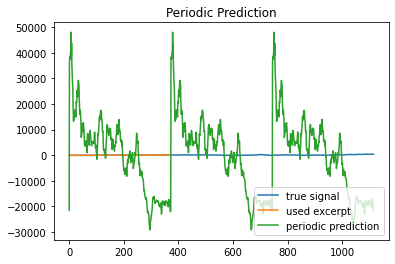

In [ ]:
test_length = 2 # expressed as number of times the excerpt length
total_length = (test_length + 1) * excerpt_length

true_signal = financial['Real_Price'][:total_length] - avg
periodic_prediction = np.tile(prediction, test_length+1)

plt.figure()
plt.plot(true_signal, label='true signal')
plt.plot(norm_excerpt, label='used excerpt')
plt.plot(periodic_prediction, label='periodic prediction')
plt.legend(loc='lower right')
plt.title('Periodic Prediction')
plt.show()